In [1]:
import copy
import pandas

ACCELERATION_NOISE_THRESHOLD_POSITIVE = 0.9
ACCELERATION_NOISE_THRESHOLD_NEGATIVE = -1.5

df = pandas.read_csv('Acceleration without g 2023-03-26 13-13-54/Raw Data.csv')

,Time (s),Linear Acceleration x (m/s^2),Linear Acceleration y (m/s^2),Linear Acceleration z (m/s^2),Absolute acceleration (m/s^2)
0,0.005272,0.006318,-0.028881,-0.042544,0.051808
1,0.015271,0.008383,-0.025119,-0.045967,0.053050
2,0.025269,0.003333,-0.008256,-0.003291,0.009492
3,0.035268,0.002054,-0.002569,0.017384,0.017693
4,0.045266,0.003272,0.005228,0.000785,0.006218
...,...,...,...,...,...
4669,46.688333,-0.008895,0.007940,-0.024799,0.027517
4670,46.698331,0.029636,0.005960,-0.025897,0.039806
4671,46.708330,0.051007,0.014396,-0.020993,0.057006
4672,46.718328,0.053246,0.033136,-0.025047,0.067531


<AxesSubplot:xlabel='Time (s)'>

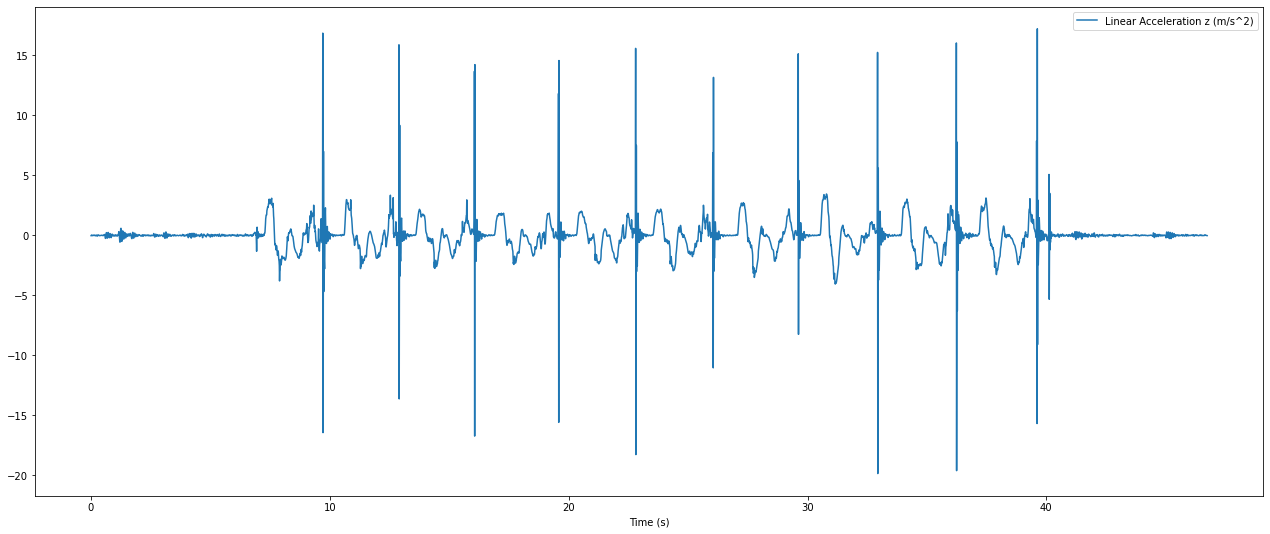

In [2]:
df.plot.line(x="Time (s)", y="Linear Acceleration z (m/s^2)", figsize=(22, 9))

### Removing noise - too high rate of change of acceleration changed to 0

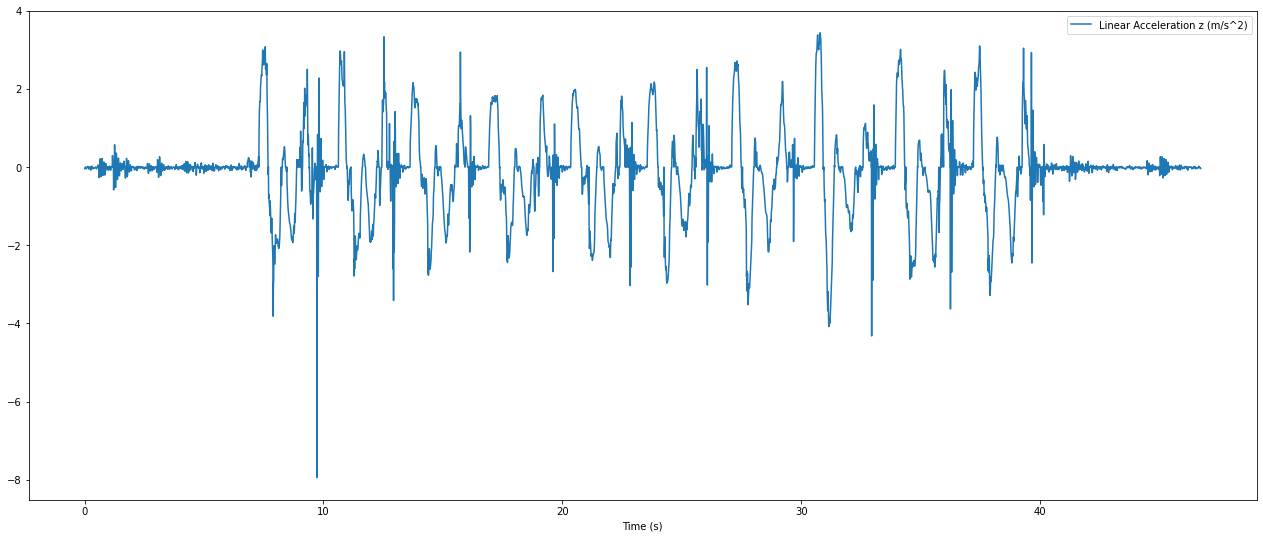

In [3]:
def filter_noise(dataframe):
  new_df = copy.deepcopy(dataframe)
  changes = new_df.pct_change()["Linear Acceleration z (m/s^2)"]
  for i, change in changes.items():
    if change > ACCELERATION_NOISE_THRESHOLD_POSITIVE or change < ACCELERATION_NOISE_THRESHOLD_NEGATIVE:
      new_df["Linear Acceleration z (m/s^2)"][i] = 0.0
  new_df.plot.line(x="Time (s)", y="Linear Acceleration z (m/s^2)", figsize=(22, 9))
  return new_df

filtered_df = filter_noise(df)

### Calculating velocity and distance from z-axis acceleration and timesteps

In [6]:
def get_velocity(acceleration: float, V0: float, delta_t: float):
  # a = (V1-V0) / t
  # V1 = a*t + V0
  return acceleration * delta_t + V0

def get_distance(delta_V: float, delta_t: float):
  # V = s/t
  # s = V*t
  return delta_V * delta_t

def get_energy_spent(mass: float, distance: float, acceleration: float):
  # A = F*s
  # F = m*a
  return mass * acceleration * distance

mass = 5
previous_time = 0.0
previous_velocity = 0.0
total_distance = 0.0
total_energy = 0.0
velocity_vec = [[]]
distance_vec = [[]]
energy_vec = [[]]

for index, row in df.iterrows():
  timestep = row["Time (s)"] - previous_time

  velocity = get_velocity(row["Linear Acceleration z (m/s^2)"], previous_velocity, timestep)
  velocity_vec.append([row["Time (s)"], velocity])

  distance_step = abs(get_distance(velocity, timestep))
  total_distance += distance_step
  distance_vec.append([row["Time (s)"], total_distance])

  energy_step = abs(get_energy_spent(mass, distance_step, row["Linear Acceleration z (m/s^2)"]))
  total_energy += energy_step
  energy_vec.append([row["Time (s)"], total_energy])

  previous_velocity = velocity
  previous_time = row["Time (s)"]

### Plotting

Distance is (m):  69.22682684600929
Energy is (J):  239.0171976101652


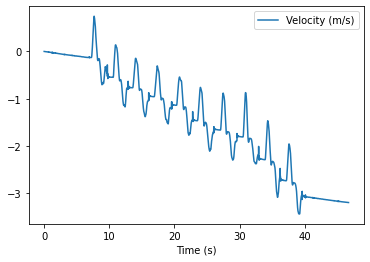

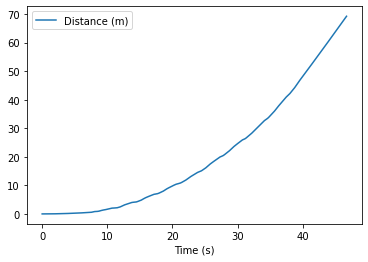

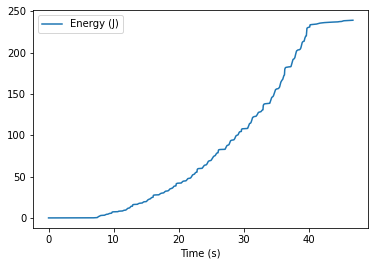

In [7]:
df_velocity = pandas.DataFrame(velocity_vec, columns=["Time (s)", "Velocity (m/s)"])
df_velocity.plot.line(x="Time (s)", y="Velocity (m/s)")
df_distance = pandas.DataFrame(distance_vec, columns=["Time (s)", "Distance (m)"])
df_distance.plot.line(x="Time (s)", y="Distance (m)")
df_energy = pandas.DataFrame(energy_vec, columns=["Time (s)", "Energy (J)"])
df_energy.plot.line(x="Time (s)", y="Energy (J)")
print("Distance is (m): ", total_distance)
print("Energy is (J): ", total_energy)